# The Layout Problem


In [44]:
import numpy as np
import random
from utils import *
import matplotlib.pyplot as plt
from human_ai import HumanAI 
from human_ai import MultiHumanAI
from model.mallows import Mallows

## Known Ground-Truth  

Suppose there are $k$ types of humans, each with **heterogeneous** ground-truth rankings. Denote the ground-truth ranking of human $i$ as $\pi_h^i$.  

If the algorithm has full knowledge of $\{\pi_h^i\}$, it can ensure that each type of human benefits from the collaboration by adopting the following strategy: 

* *Always presenting a fixed set of items to the humans. Specifically, the presented $k$ items are the $k$ top items according to humans' ground-truth rankings.*

In the following experiment, 

* we consider `num_of_humans` types of humans, each of whom has a random ground-truth ranking.
* These ground-truth rankings are **known** to the algorithm. 
* It takes the strategy by setting the $k$ top items as its first $k$ items of its ground-truth.

We can see **every human is beneficial from the collaboration**.

In [2]:
m = 10
phi = 1
for num_of_humans in range(2, 6):
    D_hs = []
    for _ in range(num_of_humans):
        pi_h_star = list(range(1, m + 1))
        random.shuffle(pi_h_star)
        D_hs.append(Mallows(m, phi, pi_h_star))

    joint_system = MultiHumanAI(m, num_of_humans, D_hs, None)
    benefits = joint_system.interaction_with_known_distribution()

[INFO] Sythesizing a layout..
[INFO] benefits: [0.3593302714709977, 0.36627696535629906]
[INFO] Sythesizing a layout..
[INFO] benefits: [0.11385074163951325, 0.33785074163951323, 0.3298507416395132]
[INFO] Sythesizing a layout..
[INFO] benefits: [0.2908507416395133, 0.35685074163951325, 0.2638507416395133, 0.20185074163951322]
[INFO] Sythesizing a layout..
[INFO] benefits: [0.09885074163951324, 0.07785074163951322, 0.1858507416395132, 0.33985074163951323, 0.01985074163951328]


### Maximizing Social Welfare Using Gradient Descent

When the ground-truth rankings of different misaligned humans are known in advance, it is desirable to find a *welfare-maximizing* layout. 
A natural idea of finding the layout would be formalizing the problem as an integer/linear program and setting the objective function as the social welfare function.
However, there might exist cases where the algorithm is unable to access all information of humans and formalize the welfare-maximizing layout problem as a integer/linear program. 
For example,

* The probability of human making mistakes is unknown. Even if the algorithm knows the ground-truth a human, it may be unclear how likely the human would mistake. For instance, when people are using an APP to search information, elder people might be more likely to miss some information than younger people, but it could be unclear to the algorithm that how large is the difference of their accuracies?
* It is unclear that how valuable the items are for these humans. From a human's perspective, $x_1$ might be the same good as the second one, or it could be far better than the second one.

Due to these issues, the formalization of the optimization problem will lack key components.
To resolve them, we consider the scenario where it is possible for the algorithm to learn about these information through observing the feedback from the human.


In [ ]:
def weighted_sample_with_fallback(items, probabilities, k):
    items = np.array(items)
    probabilities = np.array(probabilities)
    
    nonzero_mask = probabilities > 0
    weighted_items = items[nonzero_mask]
    weighted_probs = probabilities[nonzero_mask]
    
    selected = list(np.random.choice(weighted_items, size=min(k, len(weighted_items)), replace=False, p=weighted_probs / weighted_probs.sum()))
    
    if len(selected) < k:
        remaining_items = [item for item in items if item not in selected]
        additional = np.random.choice(remaining_items, size=k - len(selected), replace=False)
        selected.extend(additional)
    
    return selected

def top_k_items(items, weights, k):
    sorted_items = [item for item, _ in sorted(zip(items, weights), key=lambda x: x[1], reverse=True)]
    return sorted_items[:k]

def gradient_descent_sw(T1, T2, delta, pi_h_stars, utlities, phis, human_distribution, items, k, verbose=False):
    m = len(items)
    n = len(human_distribution)

    # initial layout x0 = (k/m, ..., k/m)
    layout = np.array([1. /m for _ in range(m)]) 
    welfares = []

    for t1 in range(T1):
        gradient = np.zeros(m)
        
        for g in range(m):
            # compute the gradient
            layout_prime = layout.copy() + delta * np.eye(m)[g]
            layout_prime /= np.sum(layout_prime)
            derivative_of_increasing_xi = 0

            for _ in range(T2):
                # pick a random human
                h = np.random.choice(range(n), p=human_distribution)
                layout_items = weighted_sample_with_fallback(items, layout_prime, k)
                layout_items_by_last_layout = weighted_sample_with_fallback(items, layout, k)
                
                # compute the gradient
                D_h = Mallows(m, phis[h], pi_h_stars[h])
                D_a_last = Mallows(m, 1, layout_items_by_last_layout + [j for j in items if j not in layout_items_by_last_layout], _fixed=True)
                D_a = Mallows(m, 1, layout_items + [j for j in items if j not in layout_items], _fixed=True)
                
                joint_system_last = HumanAI(m, D_a_last, D_h)
                joint_system = HumanAI(m, D_a, D_h)
                
                derivative_of_increasing_xi += joint_system.benefit_of_human_beyond_single_best(m, k, utlities[h]) - \
                    joint_system_last.benefit_of_human_beyond_single_best(m, k, utlities[h])
            derivative_of_increasing_xi /= T2 * delta
            gradient[g] = derivative_of_increasing_xi
        
        # update the layout
        layout += delta * gradient
        layout = np.clip(layout, 0, 1)
        if verbose:
            print(f"Gradient: {gradient}")
            print(f"Iteration {t1 + 1}:", layout)
        layout /= np.sum(layout)
        observed_welfare = 0
        layout_items = top_k_items(items, layout, k)
        D_a = Mallows(m, 1, layout_items + [j for j in range(1, m+1) if j not in layout_items], _fixed=True)
        for h in range(n):
            D_h = Mallows(m, phis[h], pi_h_stars[h])
            joint_system = HumanAI(m, D_a, D_h)
            observed_welfare += human_distribution[h] * joint_system.benefit_of_human_beyond_single_best(m, k, utlities[h])        # print(f"Iteration {t1 + 1} Observed welfare: {observed_welfare}")
        welfares.append(observed_welfare)

    plt.plot(range(len(welfares)), welfares)
    plt.xlabel("Iteration")
    plt.ylabel("Welfare")
    plt.title("Welfare over iterations")
    plt.grid()
    plt.show()
    print("Final layout: {}".format(top_k_items(items, layout, k)))

### Single Best Item

[[6, 10, 3, 8, 9, 4, 5, 7, 1, 2], [10, 4, 5, 3, 6, 7, 1, 8, 2, 9], [3, 6, 8, 9, 2, 1, 4, 7, 5, 10]]
[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[0.31087761 0.40290252 0.28621987]


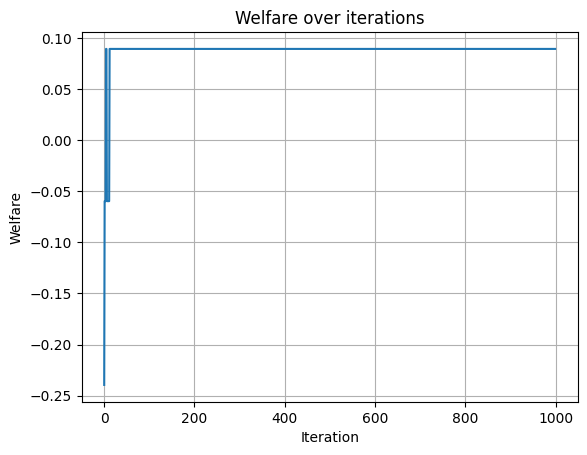

Final layout: [3, 10, 6]


In [58]:
T1 = 1000
T2 = 50
delta = 0.1

m = 10 # number of items
items = list(range(1, m + 1))
n = 3 # three agents
k = 3 # number of items to select

## Prepare ground-truth rankings and phis for different misaligned humans
pi_h_stars = [list(range(1, m + 1)) for _ in range(n)]
utlities = [[1 if i == 0 else 0 for i in range(m)] for _ in range(n)]
for i in range(n):
    random.shuffle(pi_h_stars[i])
phis = [random.uniform(0.1, 1) for _ in range(n)]
human_distribution = [random.uniform(0.1, 1) for _ in range(n)]
human_distribution /= np.sum(human_distribution)
print(pi_h_stars)
print(utlities)
print(human_distribution)

gradient_descent_sw(T1, T2, delta, pi_h_stars, utlities, phis, human_distribution, items, k)


[[4, 6, 1, 8, 3, 9, 5, 7, 10, 2], [8, 5, 6, 2, 7, 1, 4, 3, 10, 9], [2, 6, 7, 1, 9, 5, 10, 8, 3, 4]]
[[0.37519114121825325, 0.31061025456856306, 0, 0, 0, 0, 0, 0, 0, 0], [0.42953292901318774, 0.2321258918450021, 0, 0, 0, 0, 0, 0, 0, 0], [0.6554142371025939, 0.030464133356363665, 0, 0, 0, 0, 0, 0, 0, 0]]
[0.44893144 0.087008   0.46406056]


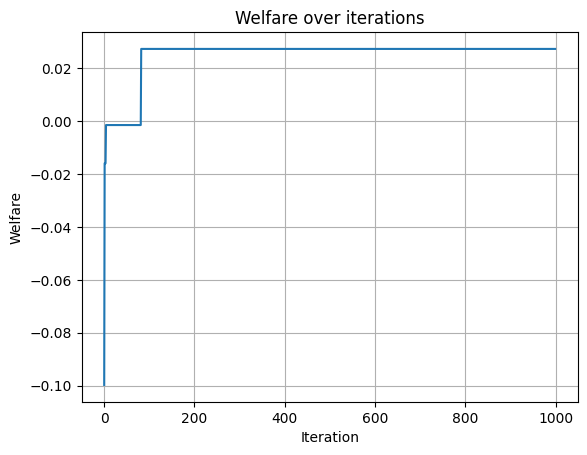

Final layout: [2, 4, 6]


In [57]:
T1 = 1000
T2 = 50
delta = 0.1

m = 10 # number of items
items = list(range(1, m + 1))
n = 3 # three agents
k = 3 # number of items to select

## Prepare ground-truth rankings and phis for different misaligned humans
pi_h_stars = [list(range(1, m + 1)) for _ in range(n)]
utlities = [[random.uniform(0, 1) if i < 2 else 0 for i in range(m)] for _ in range(n)]
for i in range(n):
    random.shuffle(pi_h_stars[i])
    utlities[i].sort(reverse=True)
phis = [random.uniform(0.1, 1) for _ in range(n)]
human_distribution = [random.uniform(0.1, 1) for _ in range(n)]
human_distribution /= np.sum(human_distribution)
print(pi_h_stars)
print(utlities)
print(human_distribution)

gradient_descent_sw(T1, T2, delta, pi_h_stars, utlities, phis, human_distribution, items, k)


## Unknown Ground-Truth

However, the ground-truth rankings may not always known in advance to the algorithm, especially in scenarios that protect user privacy.

To learn about humans' preference, algorithm usually adopt query-based learning to learn humans' preference.
We suppose the humans are interacting with the algorithm in the following way:

* At time $t$, a human comes with a type-$i$ human arriving with a probability of $p_i$.
* The algorithm presents a set of items $S_t$ to that human. She selects her favourite one from the items (but she sometimes would make mistakes). The human will get a **postive** review if the item is perfect to her and a **negative** review otherwise.
* The algorithm updates $S_t$ by always picking the items that human like the most



In [3]:
m = 10
phi = 1
for num_of_humans in range(2, 6):
    info(f"Number of humans {num_of_humans}")
    D_hs = []
    
    ## The probability of every type person arriving.
    ps = np.array([random.random() for _ in range(num_of_humans)])
    ps /= np.sum(ps)
    info("p_i: {}".format(ps))

    ## Generating ground-truth
    for _ in range(num_of_humans):
        pi_h_star = list(range(1, m + 1))
        random.shuffle(pi_h_star)
        D_hs.append(Mallows(m, phi, pi_h_star))

    ## 1000 interactions between the algorithm and these humans
    joint_system = MultiHumanAI(m, num_of_humans, D_hs, ps)
    joint_system.interaction_with_unknown_distribution(1000, 200)

[INFO] Number of humans 2
[INFO] p_i: [0.62851802 0.37148198]
[INFO] t: 0, benefits: [-0.6321492583604867, -0.6321492583604867]
[INFO] t: 200, benefits: [0.36627696535629906, -0.6321492583604867]
[INFO] t: 400, benefits: [0.36627696535629906, -0.6321492583604867]
[INFO] t: 600, benefits: [0.36627696535629906, -0.6321492583604867]
[INFO] t: 800, benefits: [0.3593302714709977, -0.6321492583604867]
[INFO] Number of humans 3
[INFO] p_i: [0.45437628 0.05007939 0.49554433]
[INFO] t: 0, benefits: [0.3348507416395132, -0.6321492583604867, -0.6321492583604867]
[INFO] t: 200, benefits: [0.2908507416395133, -0.6321492583604867, 0.35785074163951325]
[INFO] t: 400, benefits: [0.2988507416395133, -0.6321492583604867, 0.35585074163951325]
[INFO] t: 600, benefits: [0.24885074163951326, 0.35085074163951324, 0.3288507416395132]
[INFO] t: 800, benefits: [0.2718507416395133, 0.35885074163951325, 0.3298507416395132]
[INFO] Number of humans 4
[INFO] p_i: [0.33539883 0.27490237 0.1368927  0.2528061 ]
[INFO] 

## Limitation

However, the above query-based learning algorithm still has limitation. If a $p_i$ is very small, then algorithm has a very low probability of meeting a type-$i$ human.
Thus, the algorithm cannot learn the top item of the $i$-th human very well.

For example, in the above experiment with $5$ agents. The third human has a probability of $0.0198$ to appear, while is relatively low compared to other humans. As a result, her utility is still negative ($-0.632$) at the end of interaction.
So it is still possible that that human **only gets hurt** from the collaboration.

This problem also has widespread manifestations in real-world scenarios. For example, for elderly users who do not frequently use smartphones, how can AI-algorithm ensure that their preferences are met?

